# Lab Project 1
# Part 2: Digital Pulse Processing - isotope identification

## Introduction
A digital pulse processing (DPP) system will be developed from scratch, aiming at analyzing events recorded from a $\gamma$ radiation detector placed close to a $\gamma$ source.

The heavy processing part is carried out in the SoC PL, where the oscilloscope, pulse-shaping, peak-detection, and histogram computations are implemented. Moreover, the control of these processing block parameters are set using the **output registers** of the **ComBlock**, which also resides in the PL. The histogram (used to obtain the spectrum of the events) stores its results in the **ComBlock's** **True DP-RAM**, while the raw **oscilloscope** traces are streamed to the **Comblock's** **Input FIFO**.

The Zynq SoC PS commands the communication between the SoC PL and the computer using the **UDMA** library. 

This Jupyter Notebook is the interface between the SoC and the data visualization. You will interact with the SoC through UDMA to do the following:

    - Set the parameters for the pulse shaper using the ComBlock output registers
    - Set the parameters for the peak detector using the ComBlock output registers
    - Set the parameters for the oscilloscope using the ComBlock output registers
    - Acquire the computed histogram (spectrum) using the ComBlock true dual-port RAM
    - Acquire the raw pulse shapes from the oscilloscope using the ComBlock input FIFO

You will be provided with a library (DppParameters) to compute the 32-bit unsigned representation of the parameters to be written to the pulse shaper and the peak detector. 


> 🔴 **Before you continue**
> Make sure you have succesfully obtained the unique detector parameters from the previous project stage: `tauDecay` ($\tau_D$) and `tauRise` ($\tau_R$)



## Goals
    - Compute the DPP parameters using the detector paramters 'tauDecay' and 'tauRise'
    - Record and visualize the raw traces from the oscilloscope running in the SoC PL.
    - Fine tune and visualize the spectrum of the signal processed by the DPP.
    - Identify the radiation source located close to the detector, by comparing it with a known spectra database
    - (Optional) Calibrate the detector to energy scale (in keV) using the known energy peaks of the spectrum

## Procedure

- A) Import the libraries and setup the global working paramters (constants)
- B) Compute the parameters of the DPP system (pulse shaper and peak detector), using your detector's decay and rise time constants
    - You can use the multiplexer (MUX) within the PL to change the signal shown in the external oscilloscope
        - Raw input signal
        - Pulse shaper outputs
        - Peak detector output
- C) Connect to the SoC via UDMA and send the parameters for:
    - Pulse shaper
    - Peak detector
    - Oscilloscope
- D) Acquire multiple pulses from the SoC PL using the UDMA.
    - You may use the ```recordDataset``` method from the ```PulseFit``` library, if you prefer.
    - Change the oscilloscope parameters in the ComBlock to achieve the best pulse acquisition performance
        - You may change the ```Threshold``` and ```Samples_before_trigger``` (delay_max = 1023 samples). 
        - Avoid changing the ```Pulse Length``` value
- E) Acquire the spectrum computed in the ```Histogram``` block of the DPP. 
    - Clean the DP RAM contents 
    - Read the ComBlock RAM contents using the UDMA library to acquire the spectrum
        - Clean the ComBlock RAM contents once, to make sure no previous data is left
        - Plot the ComBlock RAM contents with the ```plt.plot``` method (do not use the Python built-in histogram function)
        - You may execute the acquisiton->plot process multiple times to see how the spectrum starts representing a known pattern
- F) Determine the isotope of the radiactive source that your system has detected
    - Visually inspect the shape of the spectrum and compare it with a set of known spectra of different isotopes
- G) (OPTIONAL) Calibrate the detector output into energy range (keV) using two (or more) points:
    - Photopeak and baseline may be enough to achieve a rough calibration curve.
 
Remember, the ```PulseFit.recordDataset``` method was used in the previous stage of this project

---

- Author(s): Ivan Morales, Romina Molina (MLab/ICTP) - 2023/11/23 (version 1.0)
- Update(s):

--- 

### A) Before starting
Importing libraries and initializing the detector parameters. Do not change any value if you are not sure of what they mean.

In [52]:
%matplotlib widget
import udma
import numpy as np
import matplotlib.animation
import matplotlib.pyplot as plt
from pulsefit import PulseFit
from dppparameters import DppParameters
import time
import pandas as pd 


Do not change the following parameters, unless you know the implications

In [2]:
# Total trace length (samples). This value must match the Vivado Block Design settings.
TRACE_LEN = 2048     # Number of samples to be recorded (must match with the ComBlock I-FIFO length)
SAMPLING_RATE = 50e6 # Sampling rate (fs) of the ADC (50 Msps)
ADC_RESOLUTION = 14  # Resolution of the ADC
DC_OFFSET = (2**ADC_RESOLUTION // 2) # Pulses are located at half of the amplitude

---

### B) DPP parameters


Once you are satisfied with the fitting results of the pulse shape from the previous project stage, you may proceed to compute the digital pulse processor (DPP) parameters that will be executed in the PL.

The two DPP components that require fine-tuned parameters in the next Laboratory session are:
- Pulse shaper: it transforms the incoming pulses into a trapezoid with amplitude proportional to the incoming energy of the detected event.
- Peak detector: finds individual pulse events, fed from the pulse shaper output.

Execute the following commands to translate the fitted parameters into a 32-bit unsigned representation that will be deployed in the FPGA processing blocks in the next laboratory session.

> Set the following detector constants with the values you obtained in the previous stage

In [3]:
TAU_DECAY = 1.069849e-6
TAU_RISE  = 0.3946262e-6

In [4]:
# Initializing the DppParameters library with the ADC sampling rate
dppParams = DppParameters(samplingRate = SAMPLING_RATE) # ADC sampling rate (50 Msps)

Compute the DPP Pulse Shaper parameters

In [5]:
dppParams.computeParamsShaper(
    tauD = TAU_DECAY,
    tauR = TAU_RISE
)

r1_shaper_b10_32_0 = 16466492
r2_shaper_na_32_0 = 122
r3_shaper_nb_32_0 = 127
r4_shaper_na_inv_32_0 = 536871
r5_shaper_b00_32_0 = 191325808
r6_shaper_b20_32_0 = 15948119
r7_shaper_dc_offset_32_0 = 0
r8_shaper_invertoffset_dc_offset_32_0 = 0


Compute the DPP Peak Detector parameters

In [6]:
dppParams.computeParamsPeakD()

r1_peakD_x_delay_32_0 = 18
r2_peakD_x_noise_32_0 = 328
r3_peakD_x_min_max_32_0 = 2146435564


> 🔴 **Before you continue**

The ```r4_en_pkd``` register of the *Peak Detector* IP core enables/disables its functionality. This feature is useful to execute the histogram computation only during the measurement, reducing the influence of the background radiation.

You have mapped this register to one of the ComBlock output registers and due to its functionality, it is not provided as a parameter in the ```DppParameters``` library.

Enabling the *Peak detector* is done by setting ```r4_en_pkd = 4```. To stop the histogram computation, simply reset this register.

---

### C) Interface with SoC via UDMA

> Connect to the SoC using UDMA

In [7]:
IP_ADDRESS = '192.168.1.10' # Set your ZedBoard IP Address here
IP_PORT = 7

# Create the UDMA instance and then connect to the ZedBoard. Assign it to the variable called "zedBoard"
zedBoard = udma.UDMA_CLASS(IP_ADDRESS, IP_PORT)

In [8]:
connectionStatus = 0
while(connectionStatus == 0):
    connectionStatus = zedBoard.connect()
    time.sleep(1)

> Remember to disable UDMA logging, to speed up the acquiring process

In [9]:
# Disable unused logging to speed up data transactions
_ = zedBoard.log(0)

> Set the ComBlock output register values using the DPP parameters obtained in section **(B) DPP parameters**

> Do not forget to add the `DC_OFFSET` constant to the oscilloscope threshold value

In [10]:
# Register mapping
cb_PulseLen                     = 2
cb_SampleBefore                 = 1
cb_Threshold                    = 0
cb_r1_b10                       = 3
cb_r2_na                        = 4
cb_r3_nb                        = 5
cb_r4_na_inv                    = 6
cb_r5_b00                       = 7
cb_r6_b20                       = 8
cb_r7_dc_offset                 = 9
cb_r8_invertoffset_dc_offset    = 10
cb_r1_x_delay                   = 11
cb_r2_x_noise                   = 12
cb_r3_x_min_max                 = 13
cb_r4_em_pkd                    = 14
cb_dacMux_sel                   = 15  

In [11]:
# Shaper parameters
r1_shaper_b10_32_0                      = 16466492
r2_shaper_na_32_0                       = 122
r3_shaper_nb_32_0                       = 127
r4_shaper_na_inv_32_0                   = 536871
r5_shaper_b00_32_0                      = 191325808
r6_shaper_b20_32_0                      = 15948119
r7_shaper_dc_offset_32_0                = 0
r8_shaper_invertoffset_dc_offset_32_0   = 0

# Peak detector parameters
r1_peakD_x_delay_32_0                   = 18
r2_peakD_x_noise_32_0                   = 328
r3_peakD_x_min_max_32_0                 = 2146435564
r4_peakD_em_pkd_32_0                    = 0

# Oscilloscope trigger parameters
r1_osc_threshold                        = DC_OFFSET + 1000
r2_osc_samplesBeforeTrigger             = 512
r3_osc_pulseLen                         = TRACE_LEN

> Write DPP and oscilloscope parameters using ComBlock output registers

In [12]:
zedBoard.write_reg(reg = cb_Threshold, data = r1_osc_threshold)
zedBoard.write_reg(reg = cb_SampleBefore, data = r2_osc_samplesBeforeTrigger)
zedBoard.write_reg(reg = cb_PulseLen, data = r3_osc_pulseLen)

zedBoard.write_reg(reg = cb_r1_b10, data = r1_shaper_b10_32_0)
zedBoard.write_reg(reg = cb_r2_na, data = r2_shaper_na_32_0)
zedBoard.write_reg(reg = cb_r3_nb, data = r3_shaper_nb_32_0)
zedBoard.write_reg(reg = cb_r4_na_inv, data = r4_shaper_na_inv_32_0)
zedBoard.write_reg(reg = cb_r5_b00, data = r5_shaper_b00_32_0)
zedBoard.write_reg(reg = cb_r6_b20, data = r6_shaper_b20_32_0)
zedBoard.write_reg(reg = cb_r7_dc_offset, data = r7_shaper_dc_offset_32_0)
zedBoard.write_reg(reg = cb_r8_invertoffset_dc_offset, data = r8_shaper_invertoffset_dc_offset_32_0)

zedBoard.write_reg(reg = cb_r1_x_delay, data = r1_peakD_x_delay_32_0)
zedBoard.write_reg(reg = cb_r2_x_noise, data = r2_peakD_x_noise_32_0)
zedBoard.write_reg(reg = cb_r3_x_min_max, data = r3_peakD_x_min_max_32_0)


[(1, 0), 0]

> Choose the output of the DAC Mux, according to the mapping you did in Vivado

In [13]:
mux_dac_x                       = 0 # X0
mux_dac_y                       = 1 # X1
mux_dac_y_impulse               = 2 # X2
mux_dac_y_rect                  = 3 # X3
mux_dac_peak_amp                = 4 # X4

In [29]:
zedBoard.write_reg(reg = cb_dacMux_sel, data = mux_dac_peak_amp)

[(1, 0), 0]

### D) Oscilloscope

In [30]:
# You may increase or decrease this value
PULSES_TO_RECORD = 100

> You may use the `recordDatset` method from the `PulseFit` library to record the dataset of pulses

🔴 Store the recorded pulses in a variable called `dataset` 🔴

In [31]:
# Setting up recording and analysis parameters
pulseAnalysis = PulseFit(
    pulseLenSamples = TRACE_LEN,
    samplingRate = SAMPLING_RATE,
    resolutionBits = ADC_RESOLUTION
)

In [44]:
dataset = pulseAnalysis.recordDataset(
    pulseCount = PULSES_TO_RECORD,
    udmaInstance = zedBoard
)

#### Animated plot

In [33]:
# You might not need to change these values 
PLOT_Y_AXIS_LIMITS = (8000, 16500)

Plotting your recorded dataset in oscilloscope mode

In [34]:
dataFrameToPlot = dataset # Assign here the name of the variable for the recorded pulses (default: dataset)

In [35]:
dataset.to_csv('./dataset_01.csv')

In [36]:
# General configuration for VSCode
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 125
plt.rcParams['figure.figsize']=(9, 4)
# Turn off interactive mode
plt.ioff()
fig = plt.figure()

def animatePlot(t):
    plt.cla()
    plt.plot(dataFrameToPlot.iloc[t].T.values, color='indigo')   # <- Data
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (ADC units)")
    plt.title("Oscilloscope", color='indigo')
    plt.ylim(PLOT_Y_AXIS_LIMITS[0], PLOT_Y_AXIS_LIMITS[1])
    plt.grid()

matplotlib.animation.FuncAnimation(fig, animatePlot, frames=PULSES_TO_RECORD) 

### E) Spectrum from DP-RAM

> Enable peak detector IP core.

🔴 Remember to set the corresponding register `4` to enable and reset to `0` to disable it 🔴

In [37]:
r4_peakD_em_pkd_32_0 = 4

zedBoard.write_reg(reg = cb_r4_em_pkd, data = r4_peakD_em_pkd_32_0)

[(1, 0), 0]

> Clean the RAM contents before proceeding. You may use the ```write_ram``` _UDMA_ command with an array full of zeros (```np.zeros```).

This operation will ensure that the accumulated spectrum represents only the latest measurements.

In [45]:
# Writing to ComBlock's RAM one of the provided waveforms (detailed in Table 1)
data = np.zeros(TRACE_LEN).astype(int)

zedBoard.write_ram(addr = 0,
                   offset = 0,
                   length = TRACE_LEN,
                   inc = 1,
                   TxData = data) # <--- This is the waveform variable that will be sent

[(1, 2048), 0]

> Read the contents of the ComBlock RAM

🔴 Store the RAM contents in a variable called `spectrum` 🔴

We are only interested in the RAM contents, not the metadata related to the number of read values. The variable must be a one-dimension list with length = 2048

In [42]:
spectrum = zedBoard.read_ram(0, TRACE_LEN, 1)[1]

In [53]:
df_spectrum = pd.DataFrame(spectrum)
df_spectrum.to_csv('./spectrum_01.csv')

Plotting the contents of the RAM using a ```plt.plot```.

 We are not using a ```plt.hist```, since the histogram has already been computed in the FPGA

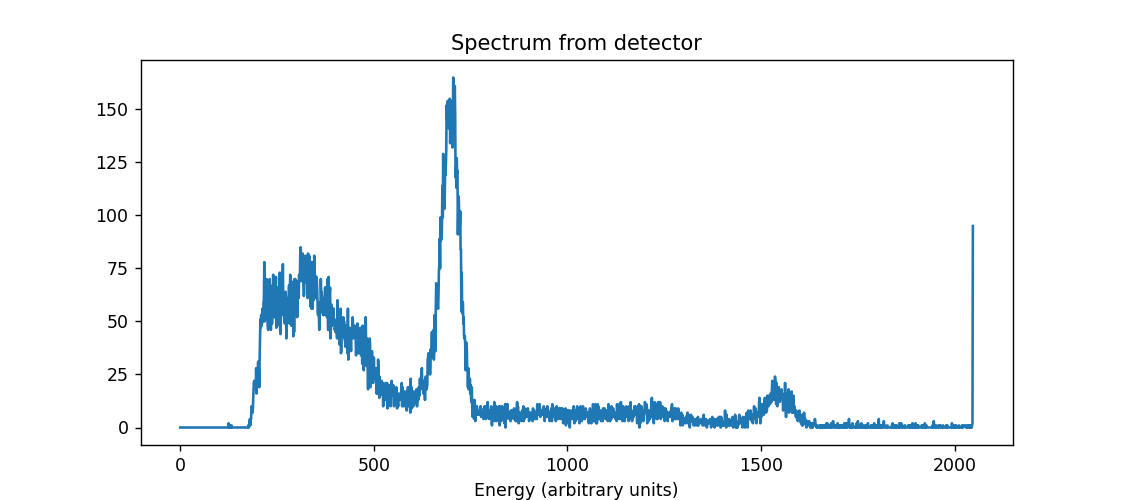

In [50]:
spectrum = np.array(spectrum).astype(np.uint32)

xAxis = np.linspace(0, TRACE_LEN - 1, TRACE_LEN)

plt.figure()
plt.title("Spectrum from detector")
plt.plot(xAxis, spectrum, '-')
plt.xlabel("Energy (arbitrary units)")
# plt.yscale('log')
plt.show()

### F) Determine the isotope

You'll find next the spectra of several known isotopes, recorded using a sodium iodide (NaI) detector. Try to focus on the histogram features, such as the peak locations and amplitude relations.

Use these features to compare the spectrum you have just obtained with the provided templates

![](../img/spectra.png)

![sources](https://gitlab.com/ictp-mlab/smr-3891/-/raw/main/Labs/LabProject/part_2/img/spectra.png?ref_type=heads)

### G) Challenge - Energy calibration and detector resolution

If you didn't use a **Cs-137** source, acquire the spectrum again during a couple of minutes for the next steps. 

Using the recorded spectrum data from the ComBlock DP-RAM, find at least one relevant peak in your spectrum and fit it to a Gaussian model to obtain the following parameters:
- Mean ($\mu_0$)
- Standard deviation ($\sigma$)

You may use (for example) the ```curve_fit``` method from the ```scipy.optimize``` library.


#### Detector resolution
Use the standard deviation of the photopeak ($\sigma$) to compute the full-width at half-maximum (FWHM).

$$FWHM = 2*\sigma \sqrt{2ln2} \approx 2.355\sigma$$

The detector resolution ($\Delta E/E$) is typically defined as the Cs-137 phototpeak FWHM, divided by the photopeak energy locaion ($\mu_0$).

$$\frac{\Delta E}{E} = \frac{FWHM}{\mu_0}$$

As a reference, the energy resolution for a typical **NaI(Tl)** detector should be arround **6%**.

#### Energy calibration

A curve of the form _Energy_ (y-axis) vs. _ADC value_ (x-axis) should be obtained.

Since you are using Cs-137 as the calibration source, the **photopeak energy** is located at **661.6 keV** (kilo electron-Volts)

Two calibration points are obtained as follows:
- The mean value of the Gaussian fit $\mu_0$ will represent the x-value of one point in the curve, with the Cs-137 photopeak position representing the y-value of this same point. 
- The other point represents the baseline (0, 0).

You should obtain a function of the form $y = a*x + b$, with:
- $b = 0$ (baseline)
- $y$: energy (in kiloelectron-Volts or keV)
- $x$: energy (in ADC units, as recorded from the detector)
- $a$: slope of the curve (obtained from the two calibration points)
